In [1]:
import numpy as np
from tqdm.notebook import tqdm
from maze_generator import generate_mazes
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image

from collections import deque

2024-06-23 23:44:43.527566: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 23:44:43.551237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 23:44:43.551281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 23:44:43.552546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 23:44:43.557978: I tensorflow/core/platform/cpu_feature_guar

In [2]:
!nvidia-smi

Sun Jun 23 23:44:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.36                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  | 00000000:01:00.0  On |                  N/A |
|  0%   38C    P8              26W / 350W |    524MiB / 12288MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)
gpus

1 Physical GPUs, 1 Logical GPU


2024-06-23 23:44:46.127231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 23:44:46.167075: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 23:44:46.167112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 23:44:46.168967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 23:44:46.168998: I external/local_xla/xla/stream_executor

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
class MazeEnvironment:
    def __init__(self, num_mazes=10, maze_size=10, batch_size=1, max_iterations=1000):
        self.num_mazes = num_mazes
        self.maze_size = 2 * maze_size + 1
        self.batch_size = batch_size
        self.max_iterations = max_iterations
        self.mazes = tf.Variable(generate_mazes(n=num_mazes, maze_size=maze_size), trainable=False)
        self.current_maze_indices = tf.Variable(tf.range(self.num_mazes), dtype=tf.int32, trainable=False)
        self.done = tf.Variable(tf.zeros(self.num_mazes, dtype=tf.bool), trainable=False)
        self.agent_positions = tf.Variable(tf.zeros((self.num_mazes, 2), dtype=tf.int32), trainable=False)
        self.previous_agent_positions = tf.Variable(tf.zeros((self.num_mazes, 2), dtype=tf.int32), trainable=False)
        self.iterations = tf.Variable(tf.zeros(self.num_mazes, dtype=tf.int32), trainable=False)
        self.position_diff = tf.constant([
            [-1, 0], 
            [0, 1], 
            [1, 0], 
            [0, -1] 
        ])
        self.shortest_path_lengths = tf.Variable(tf.zeros(self.num_mazes, dtype=tf.int32), trainable=False)
        self.shortest_paths = tf.Variable(tf.identity(self.mazes), trainable=False) 
        self.unvisited_cells = tf.Variable(tf.ones(self.num_mazes, dtype=tf.int32) * (self.maze_size ** 2), trainable=False)
        self.reset()

    def reset(self):
        self.done.assign(tf.zeros_like(self.done))
        self.iterations.assign(tf.zeros_like(self.iterations))
        self.agent_positions.assign(tf.constant([[1, 0]] * self.num_mazes))
        self.previous_agent_positions.assign(tf.constant([[1, 0]] * self.num_mazes))
        self.shortest_path_lengths.assign(tf.zeros_like(self.shortest_path_lengths))
        self.shortest_paths.assign(tf.identity(self.mazes)) 
        self.unvisited_cells.assign(tf.reduce_sum(tf.cast(self.mazes == 1, tf.int32), axis=[1, 2]))
        self.compute_shortest_paths()
        return self.mazes

    def step(self, actions):
        prev_positions_indices = tf.stack([tf.range(self.num_mazes), self.previous_agent_positions[:, 0], self.previous_agent_positions[:, 1]], axis=1)
        updated_mazes = tf.tensor_scatter_nd_update(self.mazes, prev_positions_indices, tf.ones_like(tf.gather_nd(self.mazes, prev_positions_indices)) * 2)
        self.mazes.assign(updated_mazes)
    
        self.previous_agent_positions.assign(self.agent_positions)
        new_positions = self.agent_positions + tf.gather(self.position_diff, actions)
    
        out_of_bounds = tf.logical_or(
            tf.logical_or(new_positions[:, 0] < 0, new_positions[:, 0] >= self.maze_size),
            tf.logical_or(new_positions[:, 1] < 0, new_positions[:, 1] >= self.maze_size)
        )
    
        maze_indices = tf.gather(self.mazes, self.current_maze_indices)
        new_positions_indices = tf.stack([tf.range(self.num_mazes), new_positions[:, 0], new_positions[:, 1]], axis=1)
        wall_collision = tf.gather_nd(maze_indices, new_positions_indices) == 0
        invalid_positions = tf.logical_or(out_of_bounds, wall_collision)
    
        self.agent_positions.assign(tf.where(tf.expand_dims(invalid_positions, axis=1), self.agent_positions, new_positions))
    
        self.iterations.assign_add(tf.ones_like(self.iterations))
        exceeded_iterations = tf.greater_equal(self.iterations, self.max_iterations)
        reached_exit = tf.reduce_all(tf.equal(self.agent_positions, tf.constant([[self.maze_size-1, self.maze_size-1]] * self.num_mazes)), axis=1)
        self.done.assign(tf.logical_or(self.done, tf.logical_or(exceeded_iterations, reached_exit)))
    
        if tf.reduce_any(self.done):
            self.generate_new_mazes_for_done(self.done)
    
        self.unvisited_cells.assign(tf.reduce_sum(tf.cast(self.mazes == 1, tf.int32), axis=[1, 2]))

        rewards_level1 = self.compute_reward_level1()
        rewards_level2 = self.compute_reward_level2()
        rewards_level3 = self.compute_reward_level3()

        return self.mazes, rewards_level1, rewards_level2, rewards_level3, self.done

    def compute_reward_level1(self, decay_factor=0.1):
        max_unvisited_cells = self.maze_size ** 2
        reward = tf.exp(-decay_factor * tf.cast(max_unvisited_cells - self.unvisited_cells, tf.float32) / max_unvisited_cells)
        return reward

    def compute_reward_level2(self):
        rewards = -0.1 * tf.ones(self.num_mazes, dtype=tf.float32)
        reached_exit = tf.reduce_all(tf.equal(self.agent_positions, tf.constant([[self.maze_size-1, self.maze_size-1]] * self.num_mazes)), axis=1)
        rewards = tf.where(reached_exit, rewards + 100, rewards)
        return rewards

    def compute_reward_level3(self):
        shortest_path_positions = tf.gather_nd(self.shortest_paths, tf.stack([tf.range(self.num_mazes), self.agent_positions[:, 0], self.agent_positions[:, 1]], axis=1))
        rewards = tf.where(shortest_path_positions == 1, tf.ones(self.num_mazes, dtype=tf.float32), -10 * tf.ones(self.num_mazes, dtype=tf.float32))
        return rewards

    def generate_new_mazes_for_done(self, done_mask):
        new_mazes = generate_mazes(n=tf.reduce_sum(tf.cast(done_mask, tf.int32)), maze_size=10)
        done_indices = tf.boolean_mask(tf.range(self.num_mazes), done_mask)
        self.mazes.assign(tf.tensor_scatter_nd_update(self.mazes, tf.expand_dims(done_indices, axis=1), new_mazes))
        self.reset_done_mazes(done_indices)

    def reset_done_mazes(self, done_indices):
        self.iterations.scatter_nd_update(tf.expand_dims(done_indices, axis=1), tf.zeros_like(done_indices, dtype=tf.int32))
        self.agent_positions.scatter_nd_update(tf.expand_dims(done_indices, axis=1), tf.constant([[1, 0]] * len(done_indices)))
        self.previous_agent_positions.scatter_nd_update(tf.expand_dims(done_indices, axis=1), tf.constant([[1, 0]] * len(done_indices)))
        self.done.assign(tf.zeros_like(self.done))
        self.shortest_paths.scatter_nd_update(tf.expand_dims(done_indices, axis=1), tf.gather(self.mazes, done_indices))
        self.unvisited_cells.scatter_nd_update(tf.expand_dims(done_indices, axis=1), tf.ones_like(done_indices, dtype=tf.int32) * (self.maze_size ** 2))
        self.compute_shortest_paths(done_indices)

    def get_observations(self):
        observations = tf.zeros_like(self.mazes)
        for i in range(self.num_mazes):
            pos = self.agent_positions[i]
            prev_pos = self.previous_agent_positions[i]
            observations = tf.tensor_scatter_nd_update(observations, [[i, pos[0], pos[1]]], [4])
            observations = tf.tensor_scatter_nd_update(observations, [[i, prev_pos[0], prev_pos[1]]], [3])
        
        return observations

    def visualize_mazes(self):
        num_mazes = self.num_mazes
        maze_size = self.maze_size

        fig, axes = plt.subplots(2, num_mazes, figsize=(5 * num_mazes, 15))

        for i in range(num_mazes):
            maze_copy = tf.identity(self.mazes[i])
            maze_copy = tf.tensor_scatter_nd_update(maze_copy, [self.agent_positions[i]], [4])
            maze_copy = tf.tensor_scatter_nd_update(maze_copy, [self.previous_agent_positions[i]], [3])
            axes[0, i].imshow(maze_copy.numpy(), cmap='viridis')
            axes[0, i].set_title(f'Maze {i}')
            axes[0, i].axis('off')

            shortest_paths_copy = tf.identity(self.shortest_paths[i])
            shortest_paths_copy = tf.tensor_scatter_nd_update(shortest_paths_copy, [self.agent_positions[i]], [1])
            shortest_paths_copy = tf.tensor_scatter_nd_update(shortest_paths_copy, [self.previous_agent_positions[i]], [1])
            axes[1, i].imshow(shortest_paths_copy.numpy(), cmap='viridis')
            axes[1, i].set_title(f'Shortest Paths {i}')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    def compute_shortest_paths(self, indices=None):
        if indices is None:
            indices = tf.range(self.num_mazes)
        for idx in indices.numpy():
            maze = self.mazes[idx].numpy()
            start = (1, 0)
            goal = (19, 20)
            try:
                path, length = self.bfs(maze, start, goal)
                self.shortest_path_lengths[idx].assign(length)
                path_tensor = np.zeros((21, 21), dtype=np.int32)
                for step in path:
                    path_tensor[step[0], step[1]] = 1
                self.shortest_paths[idx].assign(path_tensor)
            except NoPathFound:
                self.shortest_path_lengths[idx].assign(tf.constant(0, dtype=tf.int32))
                self.shortest_paths[idx].assign(tf.zeros((21, 21), dtype=tf.int32))
    
    def bfs(self, maze, start, goal):
        queue = deque([(start, 0)])
        visited = set([start])
        previous_vertices = {start: None}
    
        while queue:
            current_vertex, current_distance = queue.popleft()
    
            if current_vertex == goal:
                path = []
                while current_vertex is not None:
                    path.append(current_vertex)
                    current_vertex = previous_vertices[current_vertex]
                path.reverse()
                return path, current_distance
    
            for di, dj in self.position_diff.numpy():
                ni, nj = current_vertex[0] + di, current_vertex[1] + dj
                if 0 <= ni < 21 and 0 <= nj < 21 and maze[ni, nj] == 1 and (ni, nj) not in visited:
                    visited.add((ni, nj))
                    previous_vertices[(ni, nj)] = current_vertex
                    queue.append(((ni, nj), current_distance + 1))
    
        raise NoPathFound("No path found from start to goal")

class NoPathFound(Exception):
    pass

  0%|          | 0/10 [00:00<?, ?it/s]

2024-06-23 23:44:46.667627: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


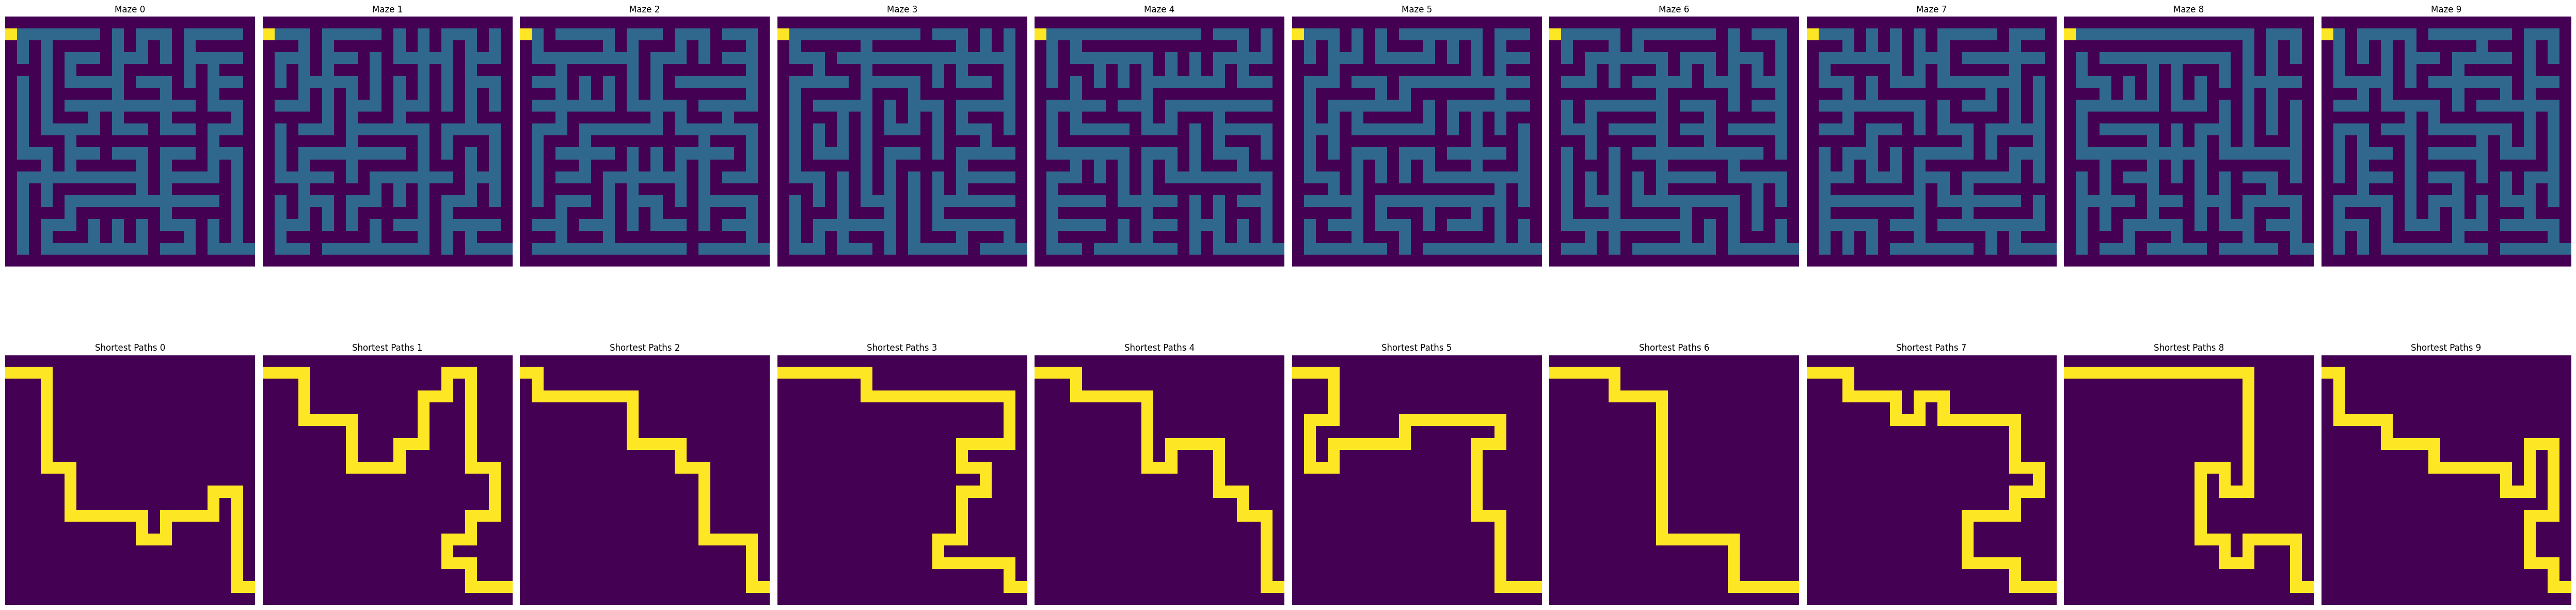

In [5]:
env = MazeEnvironment(num_mazes=10, maze_size=10, batch_size=1, max_iterations=1000)
env.visualize_mazes()

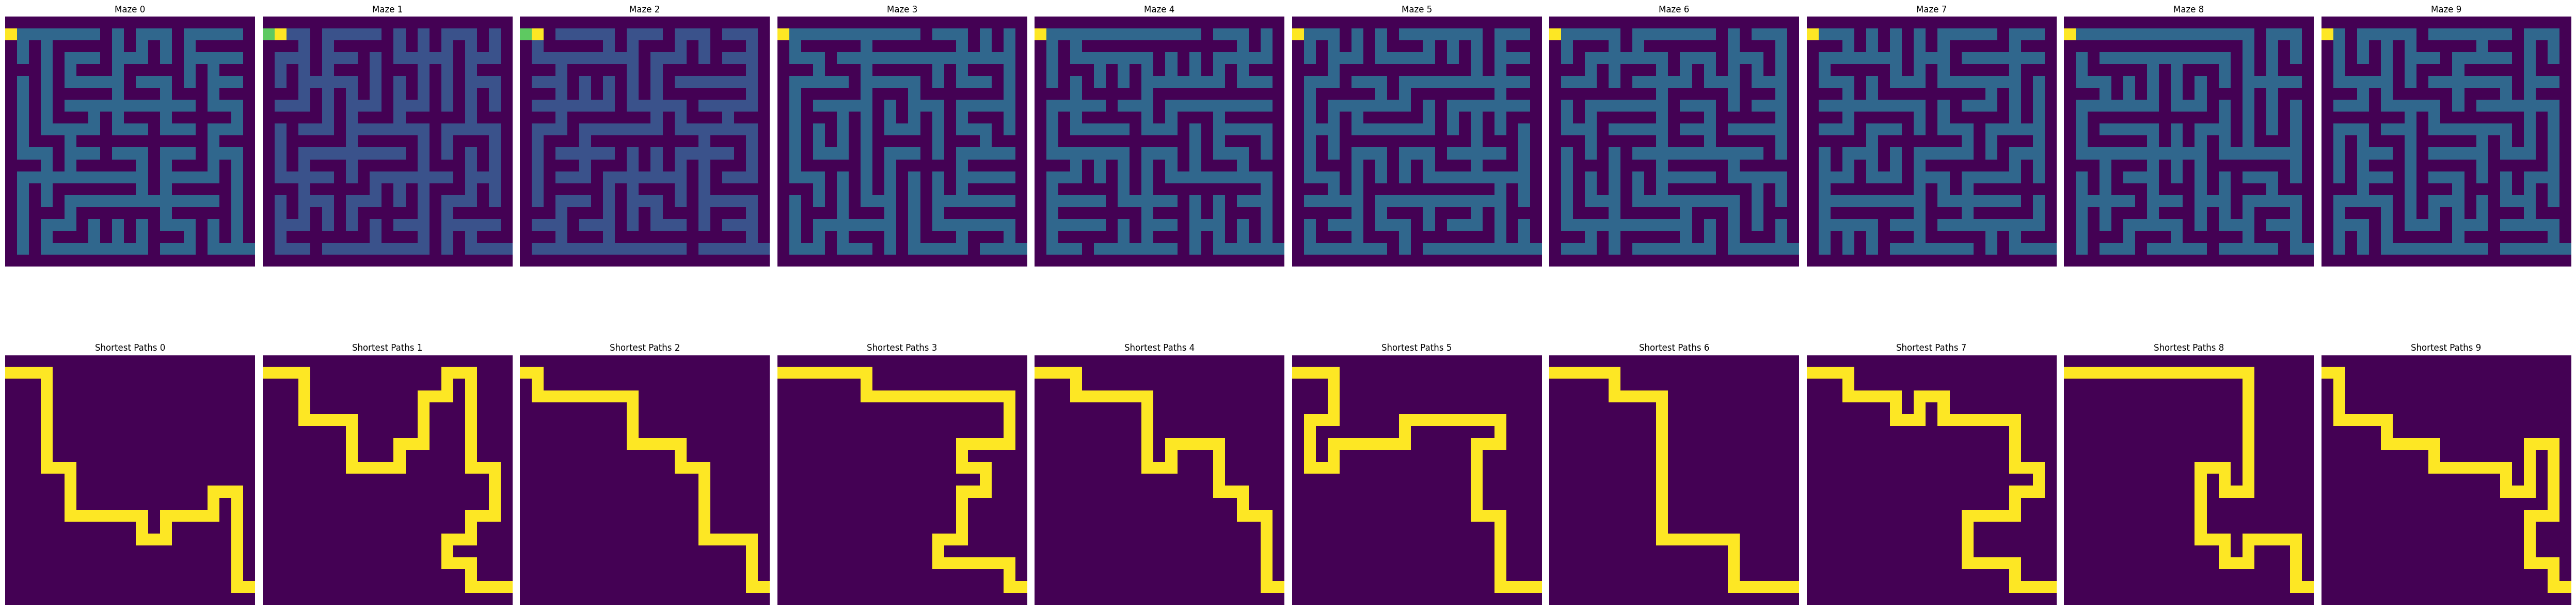

In [6]:
actions = tf.random.uniform([10], minval=0, maxval=4, dtype=tf.int32)
_ = env.step(actions)
env.visualize_mazes()

In [7]:
class DatasetReplay:
    def __init__(self, env):
        self.env = env
        self.max_steps = env.max_iterations * 101
        self.num_mazes = env.num_mazes
        self.maze_size = env.maze_size
        self.state = tf.Variable(tf.zeros((self.max_steps, self.num_mazes, self.maze_size, self.maze_size), dtype=tf.int32), trainable=False)
        self.action = tf.Variable(tf.zeros((self.max_steps, self.num_mazes), dtype=tf.int32), trainable=False)
        self.reward = tf.Variable(tf.zeros((self.max_steps, self.num_mazes), dtype=tf.float32), trainable=False)
        self.done = tf.Variable(tf.zeros((self.max_steps, self.num_mazes), dtype=tf.bool), trainable=False)

    def store_transition(self, step, state, action, reward, done):
        self.state[step].assign(state)
        self.action[step].assign(action)
        self.reward[step].assign(reward)
        self.done[step].assign(done)

    def get_batch(self, batch_size):
        indices = np.random.choice(self.max_steps, batch_size, replace=False)
        return (
            tf.gather(self.state, indices),
            tf.gather(self.action, indices),
            tf.gather(self.reward, indices),
            tf.gather(self.done, indices)
        )

In [12]:
class ActorCriticModel(tf.keras.Model):
    def __init__(self, action_dim, maze_size):
        super(ActorCriticModel, self).__init__()
        self.actor_conv = layers.Conv2D(32, kernel_size=3, strides=1, activation='relu', input_shape=(maze_size, maze_size, 1))
        self.actor_flatten = layers.Flatten()
        self.actor_dense1 = layers.Dense(64, activation='relu')
        self.actor_dense2 = layers.Dense(action_dim, activation='softmax')
        
        self.critic_conv = layers.Conv2D(32, kernel_size=3, strides=1, activation='relu', input_shape=(maze_size, maze_size, 1))
        self.critic_flatten = layers.Flatten()
        self.critic_dense1 = layers.Dense(64, activation='relu')
        self.critic_dense2 = layers.Dense(1)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        inputs = tf.expand_dims(inputs, -1)
        actor_out = self.actor_conv(inputs)
        actor_out = self.actor_flatten(actor_out)
        actor_out = self.actor_dense1(actor_out)
        actor_out = self.actor_dense2(actor_out)
        
        critic_out = self.critic_conv(inputs)
        critic_out = self.critic_flatten(critic_out)
        critic_out = self.critic_dense1(critic_out)
        critic_out = self.critic_dense2(critic_out)
        
        return actor_out, critic_out

In [9]:
class PPO:
    def __init__(self, model, lr_actor=1e-4, lr_critic=1e-3, clip_ratio=0.2, gamma=0.99, lam=0.95):
        self.model = model
        self.optimizer_actor = tf.keras.optimizers.Adam(lr_actor)
        self.optimizer_critic = tf.keras.optimizers.Adam(lr_critic)
        self.clip_ratio = clip_ratio
        self.gamma = gamma
        self.lam = lam

    def compute_loss(self, states, actions, advantages, old_log_probs):
        with tf.GradientTape() as tape:
            pi, value = self.model(states)
            log_probs = tf.math.log(tf.reduce_sum(pi * actions, axis=1) + 1e-10)
            ratio = tf.exp(log_probs - old_log_probs)
            clip_adv = tf.clip_by_value(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            loss_actor = -tf.reduce_mean(tf.minimum(ratio * advantages, clip_adv))
            loss_critic = tf.reduce_mean((value - advantages) ** 2)
        grads = tape.gradient(loss_actor, self.model.trainable_variables)
        self.optimizer_actor.apply_gradients(zip(grads, self.model.trainable_variables))
        grads = tape.gradient(loss_critic, self.model.trainable_variables)
        self.optimizer_critic.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss_actor, loss_critic

    def train(self, states, actions, rewards, dones, next_states):
        values = self.model(states)[1]
        next_values = self.model(next_states)[1]
        returns = self.compute_returns(rewards, dones, next_values, values)
        advantages = returns - values
        advantages = (advantages - tf.reduce_mean(advantages)) / (tf.math.reduce_std(advantages) + 1e-8)
        old_log_probs = tf.math.log(tf.reduce_sum(self.model(states)[0] * actions, axis=1) + 1e-10)
        for _ in range(10):
            loss_actor, loss_critic = self.compute_loss(states, actions, advantages, old_log_probs)
        return loss_actor, loss_critic

    def compute_returns(self, rewards, dones, next_values, values):
        returns = tf.zeros_like(rewards)
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * next_values[t] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            returns[t] = gae + values[t]
        return returns

In [14]:
env = MazeEnvironment(num_mazes=10, maze_size=10, batch_size=1, max_iterations=1000)
model = ActorCriticModel(action_dim=4, maze_size=21)  # maze_size = 2 * maze_size + 1
ppo = PPO(model)

for episode in range(1000):
    states = env.get_observations()
    states = tf.cast(states, tf.float32)  # Преобразование типа данных в float
    done = False
    while not done:
        actions = tf.random.categorical(tf.math.log(model(states)[0]), 1)
        actions = tf.squeeze(actions, axis=-1)  # Убеждаемся, что размерность (num_mazes,)
        next_states, rewards_level1, rewards_level2, rewards_level3, done = env.step(actions)
        next_states = env.get_observations()
        next_states = tf.cast(next_states, tf.float32)  # Преобразование типа данных в float
        loss_actor, loss_critic = ppo.train(states, actions, rewards_level1, done, next_states)
        states = next_states

    if episode % 100 == 0:
        model.save_weights(f"model_episode_{episode}")

# Сохранение финальной модели после завершения обучения
model.save_weights("model_final")

  0%|          | 0/10 [00:00<?, ?it/s]

TypeError: Cannot convert 1 to EagerTensor of dtype bool

In [ ]:
model.load_weights('model_reward1.h5')
train_model(model, trainer, env, dataset_replay, 'reward2')

In [ ]:
model.load_weights('model_reward2.h5')
train_model(model, trainer, env, dataset_replay, 'reward3')